### 기본 라이브러리 Import

In [53]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from collections import defaultdict
from PIL import Image
import numpy as np
import cv2

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms

### 데이터 불러오기

In [54]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정
traindata_dir = "../data/train"
traindata_info_file = "../data/train.csv"

# 테스트 데이터의 경로와 정보를 가진 파일의 경로를 설정
testdata_dir = "../data/test"
testdata_info_file = "../data/test.csv"

In [55]:
# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기
train_data = pd.read_csv(traindata_info_file)

# 테스트 데이터
test_data = pd.read_csv(testdata_info_file)

In [56]:
# glob을 이용하여 이미지 파일의 경로를 읽어옴
train_images = glob(traindata_dir + "/*/*")
test_images = glob(testdata_dir + "/*")
print(f"Number of train images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Number of train images: 15021
Number of test images: 10014


In [57]:
image_prop = defaultdict(list)

for i, path in enumerate(train_images):
    with Image.open(path) as img:
        image_prop['height'].append(img.height)
        image_prop['width'].append(img.width)
        image_prop['img_aspect_ratio'] = img.width / img.height
        image_prop['mode'].append(img.mode)
        image_prop['format'].append(img.format)
        image_prop['size'].append(round(os.path.getsize(path) / 1e6, 2))
    image_prop['path'].append(path)
    image_prop['image_path'].append(path.split('/')[-2] + "/" + path.split('/')[-1])

image_data = pd.DataFrame(image_prop)

image_data = image_data.merge(train_data, on='image_path')
#image_data.sort_values(by='target', inplace=True)

### 데이터 증강

In [58]:
def resize_with_padding(image, target_height, target_width):
    # 원본 이미지 크기
    h, w, _ = image.shape

    # 비율 유지
    scale = min(target_height / h, target_width / w)
    new_h = int(h * scale)
    new_w = int(w * scale)

    # 크기 조정
    resized_image = cv2.resize(image, (new_w, new_h))

    # 패딩 계산
    top = (target_height - new_h) // 2
    bottom = target_height - new_h - top
    left = (target_width - new_w) // 2
    right = target_width - new_w - left

    # 패딩 추가
    padded_image = cv2.copyMakeBorder(
        resized_image,
        top, bottom, left, right,
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0]  # 패딩 색상 (검정색)
    )

    return padded_image


In [59]:
class AlbumentationsTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 정규화, 텐서 변환
        common_transforms = [
            # A.PadIfNeeded(min_height=224*3, min_width=224*3, border_mode=0),  # 패딩을 추가하여 최소 크기까지 늘림
            A.Resize(224, 224),  # 이미지를 224x224 크기로 리사이즈
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
            ToTensorV2()  # albumentations에서 제공하는 PyTorch 텐서 변환
        ]
        
        albumentations_transform_oneof = [
              A.OneOf([
                    A.HorizontalFlip(p=1),
                    A.RandomRotate90(p=1),
                    A.VerticalFlip(p=1)            
                ], p=1),
            A.OneOf([
                    A.MotionBlur(p=1),
                    A.OpticalDistortion(p=1),
                    A.GaussNoise(p=1)                 
                ], p=1)
        ]
        
        default_transform = [
        A.RandomRotate90(p=0.5),  # 90도 단위 회전
        A.Rotate(limit=30, p=0.5),  # 랜덤 회전, 각도 제한 30도
        A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0), p=0.5),  # 랜덤 크롭 및 리사이즈
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),  # 가우시안 블러
        A.InvertImg(p=0.5),  # 이미지 반전
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),  # 가우시안 노이즈 추가
        A.Affine(scale=(0.9, 1.1), translate_percent=(0.1, 0.1), rotate=(-20, 20), p=0.5),  # Affine 변환
        ]
        
        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 랜덤 밝기 및 대비 조정 추가
            self.transform = A.Compose(
                default_transform + common_transforms
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = A.Compose(common_transforms)

    def __call__(self, image) -> torch.Tensor:
        # 이미지가 NumPy 배열인지 확인
        if not isinstance(image, np.ndarray):
            raise TypeError("Image should be a NumPy array (OpenCV format).")
        
        # 이미지에 변환 적용 및 결과 반환
        transformed = self.transform(image=image)  # 이미지에 설정된 변환을 적용
        
        return transformed['image']  # 변환된 이미지의 텐서를 반환

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


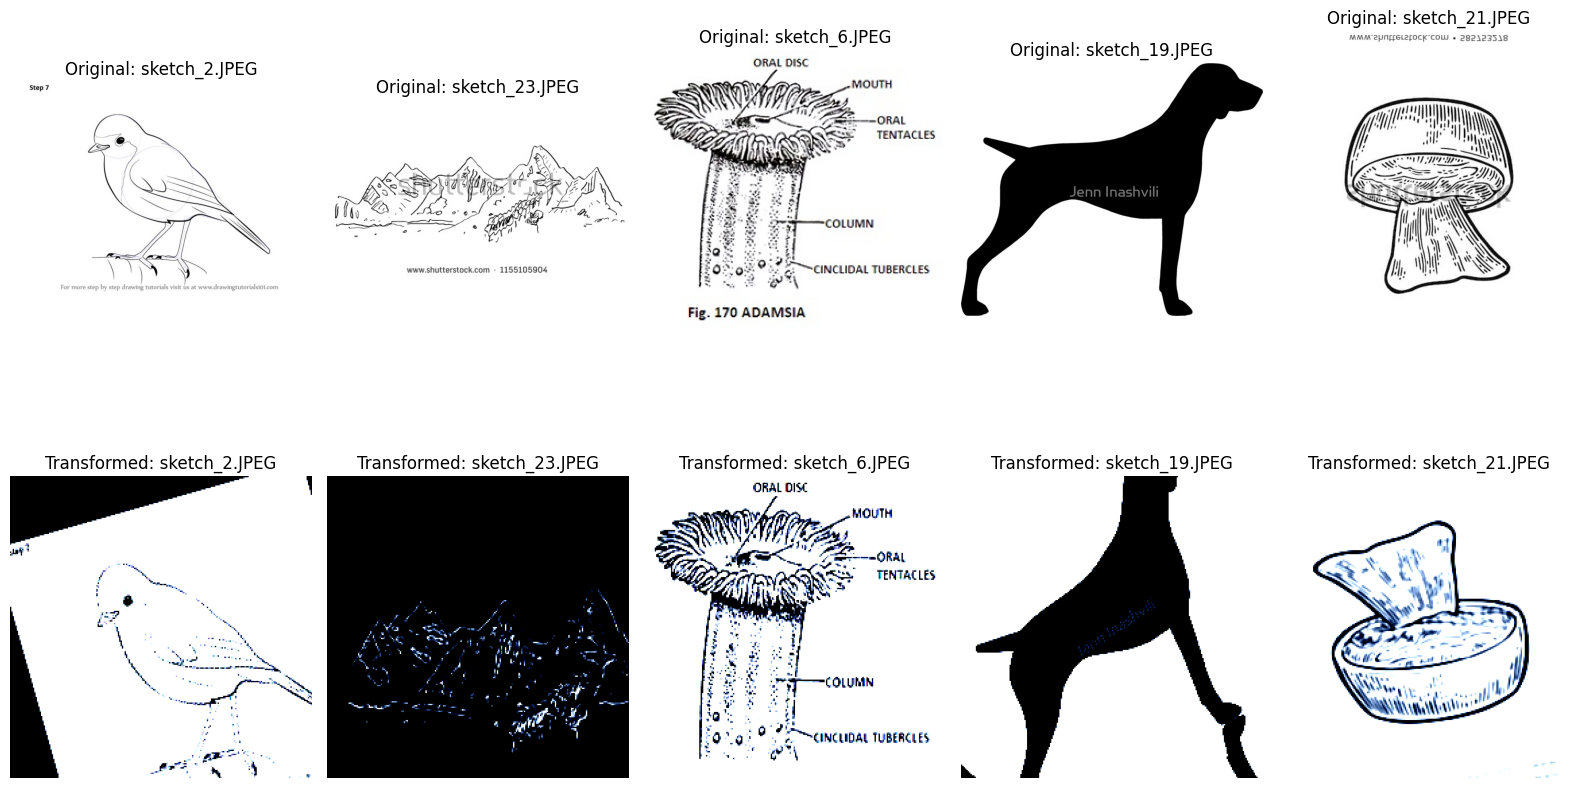

In [60]:


# transform에 알부멘테이션 사용 (사용자 정의 transform 함수)
transform = AlbumentationsTransform(is_train=True)

fig, axex = plt.subplots(2, 5, figsize=(16, 10))

# 랜덤 이미지 5개 출력
for i in range(5):
    img_path = np.random.choice(train_images)
    
    # 원본 이미지 (BGR로 읽힌 이미지를 RGB로 변환)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB 변환
    
    axex[0, i].imshow(img_rgb)
    axex[0, i].set_title(f"Original: {img_path.split('/')[-1]}")
    axex[0, i].axis('off')
    
    # 변환된 이미지 (Albumentations 적용 후 RGB로 변환)
    transformed_img = transform(image=img_rgb)  # 변환된 이미지 그대로 사용
    
    # 변환된 이미지가 딕셔너리일 경우 'image' 키가 있는지 확인
    if isinstance(transformed_img, dict):
        transformed_img = transformed_img['image']  # 딕셔너리일 경우 'image' 키 참조
    
    if transformed_img.shape[0] == 3:  # 만약 이미지가 (channels, height, width) 형식이라면
        transformed_img = np.transpose(transformed_img, (1, 2, 0))
        
    axex[1, i].imshow(transformed_img)
    axex[1, i].set_title(f"Transformed: {img_path.split('/')[-1]}")
    axex[1, i].axis('off')

plt.tight_layout()
plt.show()
